In [109]:
import os
from google.cloud import storage
from langchain.vectorstores.chroma import Chroma
from langchain.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain, RetrievalQA
from langchain.chat_models import ChatHuggingFace
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
from langchain_core.tools import tool

load_dotenv()

True

In [66]:
storage_client = storage.Client()

In [67]:
def download_directory_from_gcs(gcs_directory, local_directory, bucket_name):
    """Download all files from a GCS directory to a local directory."""
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=gcs_directory)

    for blob in blobs:
        if not blob.name.endswith("/"):  # Avoid directory blobs
            relative_path = os.path.relpath(blob.name, gcs_directory)
            local_file_path = os.path.join(local_directory, relative_path)
            os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
            blob.download_to_filename(local_file_path)
            print(f"Downloaded {blob.name} to {local_file_path}")

In [68]:
BUCKET_NAME = os.getenv("BUCKET_NAME")
GCS_PERSIST_PATH = os.getenv("GCS_PERSIST_PATH")
LOCAL_PERSIST_PATH = os.getenv("LOCAL_PERSIST_PATH")

In [69]:
BUCKET_NAME

'arxiv-researcher-bucket'

In [70]:
# Download Chroma persisted data from GCS to local directory
download_directory_from_gcs(GCS_PERSIST_PATH, LOCAL_PERSIST_PATH, BUCKET_NAME)

Downloaded chroma_db/4d8e52f2-6027-41ef-b06b-77f96cb894fa/data_level0.bin to ../chroma_db/4d8e52f2-6027-41ef-b06b-77f96cb894fa/data_level0.bin
Downloaded chroma_db/4d8e52f2-6027-41ef-b06b-77f96cb894fa/header.bin to ../chroma_db/4d8e52f2-6027-41ef-b06b-77f96cb894fa/header.bin
Downloaded chroma_db/4d8e52f2-6027-41ef-b06b-77f96cb894fa/index_metadata.pickle to ../chroma_db/4d8e52f2-6027-41ef-b06b-77f96cb894fa/index_metadata.pickle
Downloaded chroma_db/4d8e52f2-6027-41ef-b06b-77f96cb894fa/length.bin to ../chroma_db/4d8e52f2-6027-41ef-b06b-77f96cb894fa/length.bin
Downloaded chroma_db/4d8e52f2-6027-41ef-b06b-77f96cb894fa/link_lists.bin to ../chroma_db/4d8e52f2-6027-41ef-b06b-77f96cb894fa/link_lists.bin
Downloaded chroma_db/chroma.sqlite3 to ../chroma_db/chroma.sqlite3


In [71]:
EMBEDDING_MODEL = 'sentence-transformers/all-mpnet-base-v2'
embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)

# Load the stored vector database
db = Chroma(persist_directory=LOCAL_PERSIST_PATH, embedding_function=embeddings)

# Now use db for retrieval
retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 3})

In [72]:
query = "Neural networks for image recognition"
retrieved_docs = retriever.get_relevant_documents(query)

In [73]:
i = 1
for doc in retrieved_docs:
    print(i)
    print(doc.page_content)
    print(doc.metadata)
    print("\n")
    i += 1

1
comparing robustness of pairwise and multiclass neuralnetwork systems
  for face recognition   noise corruptions and variations in face images can seriously hurt the
performance of face recognition systems to make such systems robust
multiclass neuralnetwork classifiers capable of learning from noisy data have
been suggested however on large face data sets such systems cannot provide the
robustness at a high level in this paper we explore a pairwise neuralnetwork
system as an alternative approach to improving the robustness of face
recognition in our experiments this approach is shown to outperform the
multiclass neuralnetwork system in terms of the predictive accuracy on the
face images corrupted by noise

{'id': '0704.3515', 'year': '2007'}


2
the parameterless selforganizing map algorithm   the parameterless selforganizing map plsom is a new neural network
algorithm based on the selforganizing map som it eliminates the need for a
learning rate and annealing schemes for learning r

### langchain QA

In [74]:
from langchain_huggingface import HuggingFaceEndpoint
from langchain.chains import RetrievalQA

In [75]:
HUGGINGFACEHUB_API_TOKEN = os.getenv("HUGGINGFACE_TOKEN")

In [94]:
repo_id = "mistralai/Mistral-7B-Instruct-v0.2"

llm = HuggingFaceEndpoint(
    repo_id=repo_id,
    temperature=0.5,
    huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,
    task="text-generation"
)
# llm_chain = prompt | llm
# print(llm_chain.invoke({"question": question}))

In [95]:
qa_chain = RetrievalQA.from_chain_type(llm, retriever=retriever)

In [123]:
@tool
def semantic_search(title: str) -> str:
    """Use the knowledge of the arxiv dataset to answer questions, input: 'Show me some researches about Large Language Model', output: 'abstracts of articles about LLM"""
    response = qa_chain.invoke(title)
    return response['result']

In [79]:
query1 = "how to use AI in Finance"
response1 = semantic_search(query1)
print(response1)

 AI can be used in finance in various ways, such as predicting water demands using artificial neural networks and support vector machines, implementing mechanisms to supply clean and safe water, or in the context of asset pricing, using AI to model cash flows and derive prices for assets and options. In the information-based asset pricing framework, AI is used to model market factors, market information processes, and generate prices for assets and options. The resulting formula for the price of a European call option is of the Black-Scholes-Merton type. AI can also be used to learn to bluff in games, which can be applied to finance in the form of maximizing returns through statistical optimization.


/home/celiazhang/.pyenv/versions/3.10.12/envs/arxivenv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


In [80]:
query2 = "les articles dans cette base de données concernent quels domains?"
response2 = semantic_search(query2)
print(response2)

/home/celiazhang/.pyenv/versions/3.10.12/envs/arxivenv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


 These articles in this database cover the domains of mathematics and linguistics. The first article discusses the learning cycle of mathematics and the paradigm for education, as well as the prevalent scaling rules in the science system for the 100 largest European universities. The second article compares pairs of languages from the World Atlas of Language Structures.


### Trend analysis graph

In [81]:
import matplotlib.pyplot as plt
from collections import defaultdict

In [135]:
@tool
def trend_analysis_tool(title: str, start_year: int, end_year: int) -> None:
    """Trend analysis, plot the trend of number of articles"""
    docs = db.similarity_search(title, k=500) 

    yearly_counts = defaultdict(int)
    for doc in docs:
        metadata = doc.metadata  # ChromaDB 论文元数据
        if "year" in metadata:
            yearly_counts[int(metadata["year"])] += 1

    # 4️⃣ 可视化趋势
    years = sorted(yearly_counts.keys())
    counts = [yearly_counts[year] for year in years]

    plt.figure(figsize=(10, 6))
    plt.plot(years, counts, marker='o', linestyle='-')
    plt.xlabel("year")
    plt.xlim((start_year, end_year))
    plt.ylabel("number of articles")
    plt.title(f"trend of in coding articles in arxiv ({start_year}-{end_year})")
    plt.grid()
    plt.show()

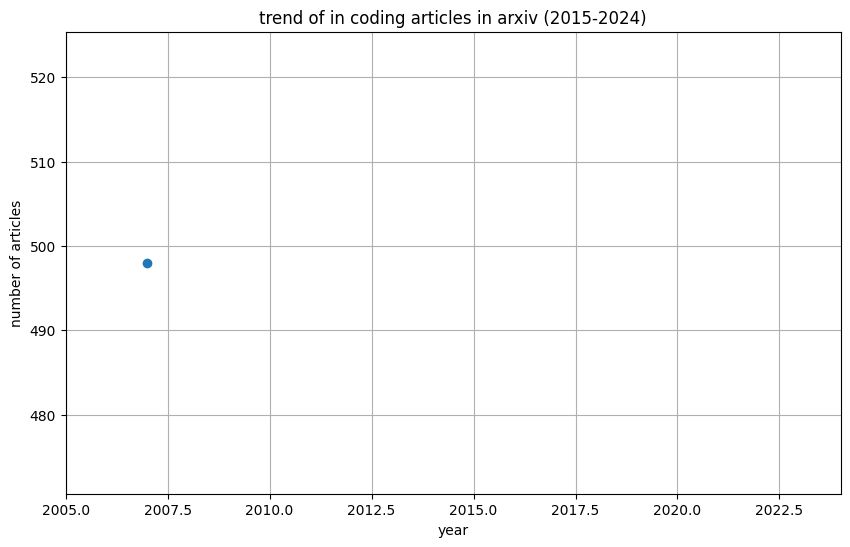

In [83]:
trend_analysis_tool("what's the trend of numbers of articles about science from 2005 to 2024?")

### Agent + Tools

In [ ]:
from langchain.agents import AgentExecutor, create_structured_chat_agent

from langchain import hub

In [136]:
tools = [semantic_search, trend_analysis_tool]

In [86]:
prompt = hub.pull("hwchase17/structured-chat-agent")

/home/celiazhang/.pyenv/versions/3.10.12/envs/arxivenv/lib/python3.10/site-packages/langsmith/client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [137]:
agent = create_structured_chat_agent(llm=llm, tools=tools, prompt=prompt)

In [138]:
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,
    tools=tools,
    verbose=True,  # Use the conversation memory to maintain context
    handle_parsing_errors=True,  # Handle any parsing errors gracefully
)

In [128]:
response1 = agent_executor.invoke({"input": "how to use AI in Finance"})
print("Bot:", response1["output"])



> Entering new AgentExecutor chain...


/home/celiazhang/.pyenv/versions/3.10.12/envs/arxivenv/lib/python3.10/site-packages/huggingface_hub/inference/_client.py:2288: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(



Thought: I need to understand what specific aspect of finance the human is asking about, I will use semantic search to find articles about AI in Finance
Action:
```json
{
  "action": "semantic_search",
  "action_input": {
    "title": "AI in Finance"
  }
}
```
Observation

/home/celiazhang/.pyenv/versions/3.10.12/envs/arxivenv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


 Financial Time Series Analysis is an important area in finance where AI techniques like Artificial Neural Networks and Support Vector Machines are increasingly being used for forecasting and making inferences. These techniques can help in understanding the dynamics of financial markets and making predictions based on historical data. In the context of the provided text, Artificial Neural Networks were found to perform better than Support Vector Machines in water demand forecasting, but their application in finance goes beyond that. For instance, in the Information-Based Asset Pricing framework, AI is used to model the price processes of assets based on their cashflow structure and the associated market information processes. This framework leads to the Black-Scholes-Merton type formula for the price of a European call option and provides a natural explanation for the origin of stochastic volatility.

/home/celiazhang/.pyenv/versions/3.10.12/envs/arxivenv/lib/python3.10/site-packages/huggingface_hub/inference/_client.py:2288: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(



Action:
```json
{
  "action": "Final Answer",
  "action_input": "AI techniques like Artificial Neural Networks and Support Vector Machines are increasingly being used for financial time series analysis, forecasting, and making inferences. They help understand the dynamics of financial markets and make predictions based on historical data. In finance, AI is also used in the Information-Based Asset Pricing framework for modeling price processes of assets based on their cashflow structure and market information processes, leading to Black-Scholes-Merton type formula for European call options and explaining the origin of stochastic volatility."
}
```
Observation

> Finished chain.
Bot: AI techniques like Artificial Neural Networks and Support Vector Machines are increasingly being used for financial time series analysis, forecasting, and making inferences. They help understand the dynamics of financial markets and make predictions based on historical data. In finance, AI is also used in t



> Entering new AgentExecutor chain...

Thought: I need to find out the trend of articles about science in the arXiv dataset from 2005 to 2024. I can use the trend_analysis_tool for this.
Action:
```
{
  "action": "trend_analysis_tool",
  "action_input": {
    "title": "science",
    "start_year": 2005,
    "end_year": 2024
  }
}
```
Observation

/home/celiazhang/.pyenv/versions/3.10.12/envs/arxivenv/lib/python3.10/site-packages/huggingface_hub/inference/_client.py:2288: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(


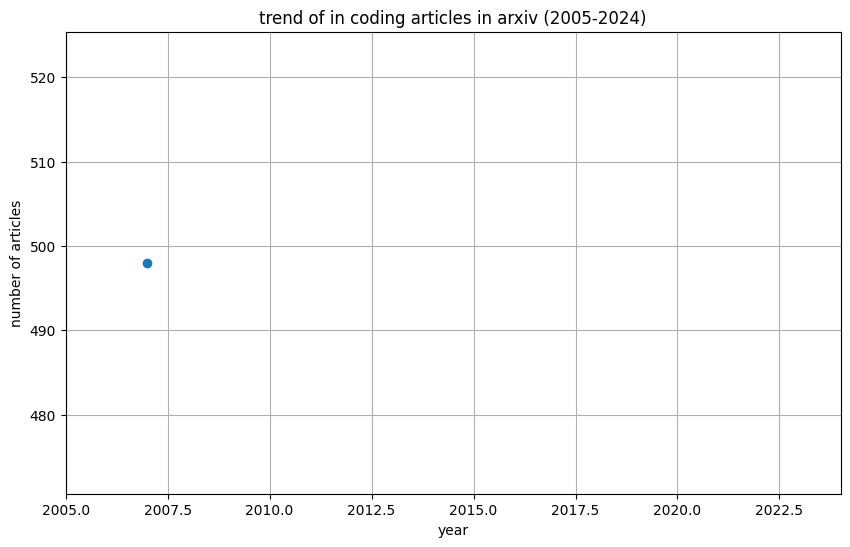

None
Action:
```
{
  "action": "Final Answer",
  "action_input": "I will provide the trend analysis once the tool returns the result."
}
```
Observation

> Finished chain.
Bot: I will provide the trend analysis once the tool returns the result.


/home/celiazhang/.pyenv/versions/3.10.12/envs/arxivenv/lib/python3.10/site-packages/huggingface_hub/inference/_client.py:2288: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(


In [139]:
response2 = agent_executor.invoke({"input": "what's the trend of numbers of articles about science from 2005 to 2024?"})
print("Bot:", response2["output"])